#### import section

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from  torchvision import datasets, transforms
import matplotlib.pyplot as plt

from pathlib import Path
from  torchinfo import summary
import os

#### Config Section

In [2]:
ROOT_DIR= Path.cwd()
DATA_DIR = ROOT_DIR.parent.resolve()/"data"
DIR_PATH = Path(DATA_DIR/"MNIST")

In [3]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=64
LEARING_RATE=1e-3
WEIGHT_DECAY=1e-5
EPOCHS=5
DOWNLOD= not DIR_PATH.exists()

### Data Processing Section

In [4]:
transform= transforms.ToTensor()
dataset = datasets.MNIST(root=DATA_DIR, train=True, download=DOWNLOD, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images), images[1].shape)

tensor(0.) tensor(1.) torch.Size([1, 28, 28])


### Model Structure

In [6]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
def train(model, dataset, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)

            loss = criterion(recon, img)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [8]:
model = Autoencoder()
max_epochs = 5
outputs = train(model, dataset=dataset, num_epochs=max_epochs)

Epoch:1, Loss:0.0104
Epoch:2, Loss:0.0050
Epoch:3, Loss:0.0036
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0026


In [9]:
def plot_fig(outputs):
    for k in range(0, max_epochs, 1):
        plt.figure(figsize=(9, 2))
        imgs = outputs[k][1].detach().numpy()
        recon = outputs[k][2].detach().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.imshow(item[0])
            
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            plt.imshow(item[0])

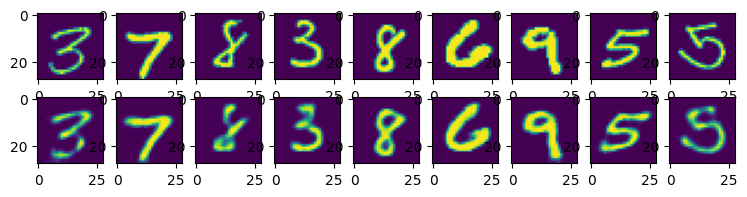

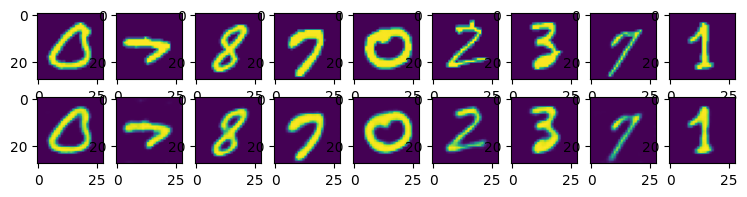

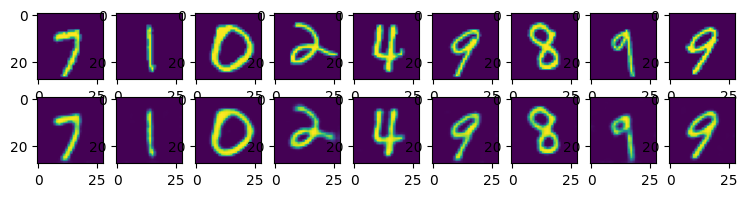

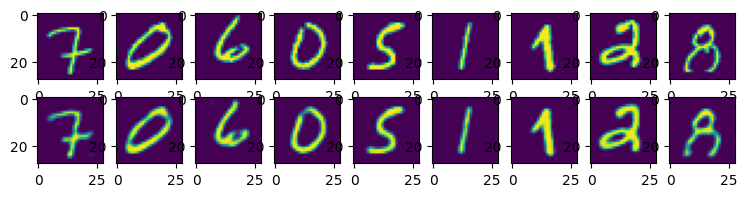

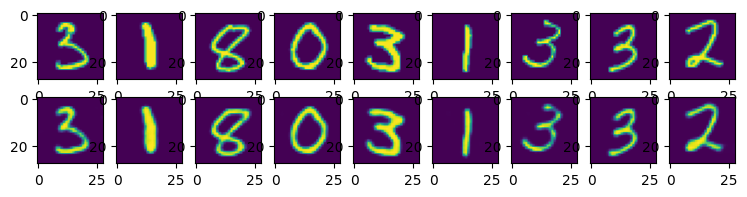

In [10]:
plot_fig(outputs)

#### Structure in the Embeddings:


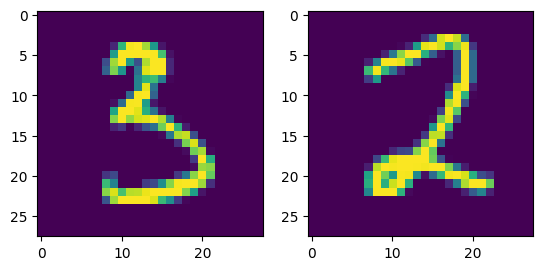

In [11]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

In [12]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

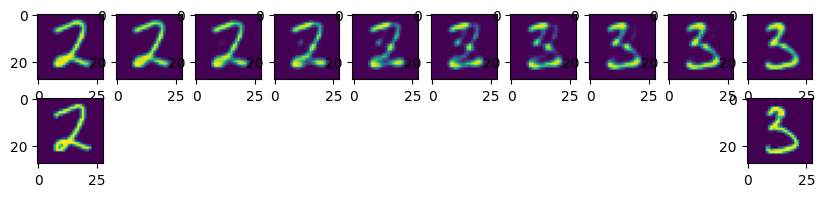

In [13]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

In [14]:
def interpolate(index1, index2):
    x1 = dataset[index1][0]
    x2 = dataset[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

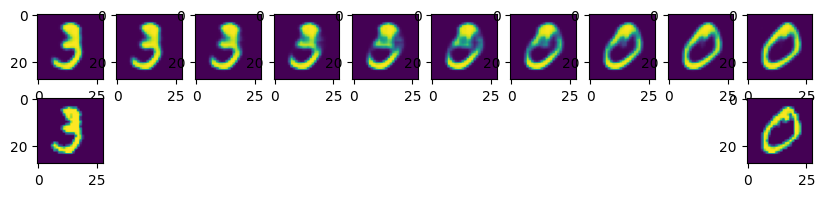

In [15]:
interpolate(1, 10)